# Federated Learning for Spatio-Temporal Predictions

In [3]:
# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# !pip install --quiet tensorflow_federated
# !pip install --quiet tf-nightly

# NOTE: Jupyter requires a patch to asyncio.
# !pip install --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [4]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time
import glob
from datetime import datetime
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
import datetime

In [7]:
%load_ext tensorboard

# 1. Data Preprocessing

## 1.1 Samples (indexed by experiment)

In [ ]:
path = '../data/avoidance_20200131_204454.dat'

samples_central = {}

for filename in glob.iglob(path):
    print(filename)
    exp_id = filename[-10:-4]
    count = 0
    samples_central.update({exp_id : {}})
    samples_central[exp_id].update({count : []})
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            x1 = float(data[3])
            x2 = float(data[4])
            samples_central[exp_id][count].append((x1, x2))
            # assumption that trajectories are 99 steps
            if len(samples_central[exp_id][count]) == 99:
                del samples_central[exp_id][count][98] # easier with even length
                count+=1
                samples_central[exp_id].update({count : []})
    # delete last empty trajectory
    del samples_central[exp_id][count]

## 1.2 Samples (indexed by experiment, client and collection time)

In [8]:
path = '../data/avoidance_20200131_204454.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {} #samples{ <exp_id> : {<rid>: { <traj_id> : { 'traj' : [], 'end' : <time_collected> }}}

for filename in glob.iglob(path):
    print(filename)
    exp_id = filename[-10:-4]
    last_sample_keys = {}
    samples.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = int(data[0])
            t = int(data[2])
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples[exp_id].keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[exp_id][rid]):
                    samples[exp_id][rid][last_key] = {'traj': [], 'end' : 0}
                samples[exp_id][rid][last_key]['traj'].append((x1, x2))
                samples[exp_id][rid][last_key]['end'] = t
                if len(samples[exp_id][rid][last_key]['traj']) == 99:
                    del samples[exp_id][rid][last_key]['traj'][98]
                    samples[exp_id][rid][last_key]['end'] = t
                    last_sample_keys[rid]+=1
            else:
                samples[exp_id].update({rid: {}})
                samples[exp_id][rid].update({0: {'traj': [(x1, x2)], 'end': 0}})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[exp_id][rid] and len(samples[exp_id][rid][last_key]) != 0):
                last_sample_keys[rid]+=1

../data/avoidance_20200131_204454.dat


## 1.3 Communication graph 

In [ ]:
path = '../data/G_avoidance_20200131_204454.dat'

neighbors = {}  #neigbors{ <exp_id> : {<rid>: { <t> : [<neighbors>]}}

for filename in glob.iglob(path):
    print(filename)    
    exp_id = filename[-10:-4]
    neighbors.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        rid = int(data[0])
        t = int(data[1])
        nid = int(data[2])
        if(t != 0):
            if(rid not in neighbors[exp_id].keys()):
                neighbors[exp_id].update({rid: {}})
            if(t not in neighbors[exp_id][rid].keys()):
                neighbors[exp_id][rid].update({t:[]})
            neighbors[exp_id][rid][t].append(nid)

## 1.4 Format checks

In [ ]:
print(samples.keys())
print(len(samples['205449'][1].keys()))

In [ ]:
for k,v in samples['204454'].items():
    for kk, vv in v.items():
        if len(vv['traj']) != 98:
            print(len(v),len(vv['traj']))

In [ ]:
for k,v in samples_central['205449'].items():
        if len(v) != 98:
            print(k,len(v))

In [ ]:
# print(samples_central['205449'][1])
print(len(samples_central['204454'].keys()))

# 2. Model Definition

## 2.1 Parameters

In [9]:
EMBEDDING_SIZE = 32
DROP_RATE = 0.3
NUM_OUTPUTS = 2

SEQ_LENGTH = 49
DIM_INPUT = 2

In [10]:
sample_shape = (SEQ_LENGTH, DIM_INPUT)

## 2.2 Simple LSTM 

In [11]:
def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-10.,input_shape=sample_shape),
    tf.keras.layers.LSTM(EMBEDDING_SIZE,
                         return_sequences=True,
                         input_shape=sample_shape),
    tf.keras.layers.Dense(NUM_OUTPUTS)
    ])
#     tf.keras.layers.Dropout(DROP_RATE),

In [ ]:
simple_lstm.save('lstm.h5') 

## 2.3 Custom loss functions (todo)

In [ ]:
def r3_bivariate_gaussian_loss(true, pred):
    """
    Rank 3 bivariate gaussian loss function
    Returns results of eq # 24 of http://arxiv.org/abs/1308.0850
    :param true: truth values with at least [mu1, mu2, sigma1, sigma2, rho]
    :param pred: values predicted from a model with the same shape requirements as truth values
    :return: the log of the summed max likelihood
    """
    x_coord = true[:, :, 0]
    y_coord = true[:, :, 1]
    mu_x = pred[:, :, 0]
    mu_y = pred[:, :, 1]

    # exponentiate the sigmas and also make correlative rho between -1 and 1.
    # eq. # 21 and 22 of http://arxiv.org/abs/1308.0850
    # analogous to https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/model.py#L326
    sigma_x = K.exp(K.abs(pred[:, :, 2]))
    sigma_y = K.exp(K.abs(pred[:, :, 3]))
    rho = K.tanh(pred[:, :, 4]) * 0.1  # avoid drifting to -1 or 1 to prevent NaN, you will have to tweak this multiplier value to suit the shape of your data

    norm1 = K.log(1 + K.abs(x_coord - mu_x))
    norm2 = K.log(1 + K.abs(y_coord - mu_y))

    variance_x = K.softplus(K.square(sigma_x))
    variance_y = K.softplus(K.square(sigma_y))
    s1s2 = K.softplus(sigma_x * sigma_y)  # very large if sigma_x and/or sigma_y are very large

    # eq 25 of http://arxiv.org/abs/1308.0850
    z = ((K.square(norm1) / variance_x) +
         (K.square(norm2) / variance_y) -
         (2 * rho * norm1 * norm2 / s1s2))  # z → -∞ if rho * norm1 * norm2 → ∞ and/or s1s2 → 0
    neg_rho = 1 - K.square(rho)  # → 0 if rho → {1, -1}
    numerator = K.exp(-z / (2 * neg_rho))  # → ∞ if z → -∞ and/or neg_rho → 0
    denominator = (2 * np.pi * s1s2 * K.sqrt(neg_rho)) + epsilon()  # → 0 if s1s2 → 0 and/or neg_rho → 0
    pdf = numerator / denominator  # → ∞ if denominator → 0 and/or if numerator → ∞
    return K.log(K.sum(-K.log(pdf + epsilon())))  # → -∞ if pdf → ∞

# 3. Datasets 

## 3.1 Utilities

In [ ]:
def _create_series_examples_from_dict(data_dict, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(data_dict.values())
    array_dataset = np.asarray(list_dataset)
    for i in range(start_index, end_index):
        data.append(array_dataset[i][:history_size])
        labels.append(array_dataset[i][history_size:])
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

In [ ]:
def create_training_and_val_sets(data_dict, past_history=PAST_HISTORY, future_target=PAST_HISTORY):
    
    x_train = np.zeros((1, past_history, DIM_INPUT))
    y_train = np.zeros((1, future_target, DIM_INPUT))
    x_val = np.zeros((1, past_history, DIM_INPUT))
    y_val = np.zeros((1, future_target, DIM_INPUT))

    for v in data_dict.values():
        tot_samples = len(v)
        train_split = round(TRAIN_RATIO * tot_samples)
        x_train_tmp, y_train_tmp = _create_series_examples_from_dict(v, 0, train_split, past_history)
        x_val_tmp, y_val_tmp = _create_series_examples_from_dict(v, train_split, tot_samples, past_history)
        x_train = np.concatenate([x_train, x_train_tmp], axis=0)
        y_train = np.concatenate([y_train, y_train_tmp], axis=0)
        x_val = np.concatenate([x_val, x_val_tmp], axis=0)
        y_val = np.concatenate([y_val, y_val_tmp], axis=0)
        
    return x_train, x_val, y_train, y_val

In [ ]:
def create_datasets(x_train, x_val, y_train, y_val):
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return train_set, val_set

## 3.2 Centralized

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO =  1 - TRAIN_RATIO
PAST_HISTORY = 49
TIME_STEP = 0.1

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [ ]:
x_train_C, x_val_C, y_train_C, y_val_C = create_training_and_val_sets(samples_central)

In [ ]:
train_set_C, val_set_C = create_datasets(x_train_C, x_val_C, y_train_C, y_val_C)

In [ ]:
print(train_set_C)

In [ ]:
for x, y in val_set_C.take(1):
    print(simple_lstm.predict(x).shape)

# 4. Training

## 4.1 Centralized 

### 4.1.1 Utilities

In [ ]:
# Create new callback
class MyHistory(tf.keras.callbacks.Callback):
    """Adapted from https://github.com/keras-team/keras/blob/master/keras/callbacks/callbacks.py#L614"""

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.timestamps = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        self.timestamps.append(datetime.datetime.now())
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

### 4.1.2 Parameters

In [ ]:
EVALUATION_INTERVAL = 50
EPOCHS = 150  

### 4.1.3 Training loop

In [ ]:
# Instantiate callback
myHistory = MyHistory()

In [ ]:
simple_lstm = create_model()

In [ ]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

simple_lstm.compile(optimizer='SGD',
        loss='mean_squared_error')
simple_lstm.fit(train_set_C, epochs=EPOCHS,
              steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=val_set_C, validation_steps=50,
              callbacks=[tensorboard_callback, myHistory])

# Note: with the regularization loss, it's normal that the validation loss is smaller than the training loss!

In [ ]:
# print(centralized.history['loss'])
# print(centralized.history['val_loss'])
print(myHistory.timestamps[0])
print(vars(myHistory))

In [ ]:
tensorboard --logdir=logs/ --port=6006

## 4.2 Federated Averaging in Server Setting

### 4.2.1 Parameters

In [12]:
EXP_DURATION = 100000
BATCH_SIZE = 30 #DATASET_PARTITION
LOCAL_EPOCHS = 1 # 10 100
TRAIN_FRAC = 0.8
NUM_ROUNDS = 100
ROUND_DURATION = int(EXP_DURATION / NUM_ROUNDS)

TRAIN_RATIO = 0.8
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
FUTURE_TARGET = 49

In [13]:
print(samples.keys())

dict_keys(['204454'])


In [14]:
for i in range(1,len(samples['204454'])+1):
    print(len(samples['204454'][i]))

3373
3471
3083
3023
2345
3397
3023
2284
3389
2824


### 4.2.2 Utilities

In [15]:
 def _create_series_examples_from_batch(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset)
    array_dataset = np.asarray(list_dataset)
    for i in range(start_index, end_index):
        data.append(array_dataset[i][:history_size])
        labels.append(array_dataset[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

In [16]:
def create_training_and_val_batch(batch, past_history=PAST_HISTORY, future_target=PAST_HISTORY):
    
    x_train = np.zeros((1,PAST_HISTORY,2))
    y_train = np.zeros((1,FUTURE_TARGET,2))
    x_val = np.zeros((1,PAST_HISTORY,2))
    y_val = np.zeros((1,FUTURE_TARGET,2))
    for v in batch:
        tot_samples = len(v)
        train_split = round(TRAIN_RATIO * tot_samples)
        print(len(v), train_split)
        x_train_tmp, y_train_tmp = _create_series_examples_from_batch(v, 0, train_split, PAST_HISTORY)
        x_val_tmp, y_val_tmp = _create_series_examples_from_batch(v, train_split, tot_samples, PAST_HISTORY)
        x_train = np.concatenate([x_train, x_train_tmp], axis=0)
        y_train = np.concatenate([y_train, y_train_tmp], axis=0)
        x_val = np.concatenate([x_val, x_val_tmp], axis=0)
        y_val = np.concatenate([y_val, y_val_tmp], axis=0)
        
    return x_train, x_val, y_train, y_val

In [24]:
def create_datasets_FA(x_train, x_val, y_train, y_val):
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_set = train_set.cache().batch(BATCH_SIZE).repeat()
    val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_set = val_set.cache().batch(BATCH_SIZE).repeat()
    return train_set, val_set

In [18]:
def average_weights(weights):
    avg = np.zeros_like(trainable_weights[1][1])
    count = 0
    for k,v in weights.items():
        if(len(v) != 0):
            avg = np.add(avg, v)
            count += 1
    if(count != 0):
        avg = avg/count
    avg = np.squeeze(avg)
    return avg           

In [19]:
# Create new callback
class LocalHistory(tf.keras.callbacks.Callback):
    """Adapted from https://github.com/keras-team/keras/blob/master/keras/callbacks/callbacks.py#L614"""

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.timestamps = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        self.timestamps.append(datetime.datetime.now())
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

### 4.2.3 Rounds by global clock and data 

In [27]:
from tensorflow.keras.models import load_model

In [29]:
history = {}

# Load the pre-trained LSTM
#  create_model() #tf.keras.models.load_model('pretrained_lstm.h5', compile=False)

# For each experiment
for exp in samples.keys():
    
    history.update({exp : {}})
    
    # Per experiment settings 
    num_robots = len(samples[exp].keys())
    
    for i in range(1, num_robots + 1):
        history[exp].update({i : {}})
    
    # Un-synch clocks by random integer (todo)
    time_offsets = np.random.randint(0, 10, size=(num_robots,))
    # Set global clock to 0
    global_clock = 0
    round_num = 1
    
    # Initialize weights
    trainable_weights = {}
    w  = [v.numpy() for v in local_lstm.trainable_weights]
    w_list = [[w] for i in range(num_robots)]
    trainable_weights[0] = {}
    trainable_weights[round_num] = {k : v for (k, v) in zip(range(1, num_robots + 1), w_list)}
    
    leftover_samples_buffer = {}
    
    # buffer of last data index of previous round for each robot
    last_idx_previous_round = np.zeros(num_robots, dtype=int)
    
    for t in range(ROUND_DURATION, EXP_DURATION, ROUND_DURATION):
        
        print("Round ", round_num)
        
        # One round for each robot: data collection, local training and global update
        for i in samples[exp].keys():
            
            tf.keras.backend.clear_session()
            
            print("Robot ", i)
            
            robot_samples = samples[exp][i]
            
            batch = []
            
            # Get data index at time of round
            cond = True
            current_idx =  last_idx_previous_round[i-1]
            while(cond):
                current_idx+=1
                if(robot_samples[current_idx]['end'] > t):
                    cond = False
            
            num_samples = current_idx - last_idx_previous_round[i-1]
            
            print(current_idx, num_samples)
            
             # Check that we have enough data collected to participate in the round
            if(num_samples >= BATCH_SIZE):
                # Take extra data collected before end of round
                tmp = [robot_samples[j]['traj'] for j in range(last_idx_previous_round[i-1], current_idx)]
                batch.append(tmp)
                # Take remaining data from previous round
                if(i in leftover_samples_buffer.keys() and len(leftover_samples_buffer[i]) > 0):
                    batch.append(leftover_samples_buffer[i])
                    leftover_samples_buffer[i] = []
            # Check that we have enough previous data      
            elif(i in leftover_samples_buffer.keys() 
                 and (len(leftover_samples_buffer[i]) + num_samples) >= BATCH_SIZE): 
                batch.append(leftover_samples_buffer[i])
                leftover_samples_buffer[i] = []
            else:
                if(i not in leftover_samples_buffer.keys()):
                    leftover_samples_buffer.update({i: []})
                leftover_samples_buffer[i] = [robot_samples[j]['traj'] for j in range(last_idx_previous_round[i-1], current_idx)]
                last_idx_previous_round[i-1] = current_idx
                print('Robot not participating', i)
                continue
            last_idx_previous_round[i-1] = current_idx
            
            # Get weights
            current_weights = average_weights(trainable_weights[round_num])
            
#             # Perform local training
            
            # Create datasets
            x_train_FA, x_val_FA, y_train_FA, y_val_FA = create_training_and_val_batch(batch)
            train_batch, val_batch = create_datasets_FA(x_train_FA, x_val_FA, y_train_FA, y_val_FA)
#             # Clone simple_lstm and initialize it with newest weights
            local_lstm = tf.keras.models.load_model('lstm.h5')
            keras_model_clone = tf.keras.models.clone_model(local_lstm)
            keras_model_clone.compile(optimizer='SGD', loss='mean_absolute_error')
            keras_model_clone.set_weights(current_weights)
            l_history = LocalHistory()
            tmp = keras_model_clone.fit(train_batch, epochs=LOCAL_EPOCHS,
              steps_per_epoch=len(x_train_FA),
              validation_data=val_batch, 
              validation_steps=len(x_val_FA),
              callbacks=[l_history])
#             # Write weights 
            if((round_num+1) not in trainable_weights.keys()):
                trainable_weights.update({(round_num+1): {}})
            trainable_weights[round_num+1].update({i: keras_model_clone.get_weights()})
            # Write metrics
            history[exp][i].update({round_num : l_history})
            %xdel l_history          
            %xdel tmp
            
            tf.keras.backend.clear_session()
        round_num+=1

Round  1
Robot  1
24 24
Robot not participating 1
Robot  10
22 22
Robot not participating 10
Robot  2
23 23
Robot not participating 2
Robot  3
30 30
30 24
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 2s 93ms/step - loss: 1.1899 - val_loss: 1.1569
Robot  4
28 28
Robot not participating 4
Robot  5
23 23
Robot not participating 5
Robot  6
25 25
Robot not participating 6
Robot  7
40 40
40 32
Train for 33 steps, validate for 9 steps
33/33 [==============================] - 2s 71ms/step - loss: 1.0925 - val_loss: 0.8078
Robot  8
24 24
Robot not participating 8
Robot  9
31 31
31 25
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 2s 86ms/step - loss: 1.0635 - val_loss: 0.8369
Round  2
Robot  1
55 31
31 25
24 19
Train for 45 steps, validate for 12 steps
45/45 [==============================] - 4s 92ms/step - loss: 0.7317 - val_loss: 0.4126
Robot  10
60 38
38 30
22 18
Train for 49 steps, validate for 13 steps
49/49 [=========

Train for 54 steps, validate for 14 steps
54/54 [==============================] - 5s 84ms/step - loss: 0.1456 - val_loss: 0.1356
Robot  3
214 44
44 35
Train for 36 steps, validate for 10 steps
36/36 [==============================] - 3s 83ms/step - loss: 0.1371 - val_loss: 0.1612
Robot  4
165 37
37 30
27 22
Train for 53 steps, validate for 13 steps
53/53 [==============================] - 3s 64ms/step - loss: 0.1484 - val_loss: 0.1566
Robot  5
95 11
Robot not participating 5
Robot  6
198 41
41 33
Train for 34 steps, validate for 9 steps
34/34 [==============================] - 3s 74ms/step - loss: 0.1614 - val_loss: 0.1317
Robot  7
187 30
30 24
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 3s 102ms/step - loss: 0.1672 - val_loss: 0.1641
Robot  8
62 16
Robot not participating 8
Robot  9
161 42
42 34
Train for 35 steps, validate for 9 steps
35/35 [==============================] - 3s 73ms/step - loss: 0.1638 - val_loss: 0.1409
Round  6
Robot  1
175 25

Train for 36 steps, validate for 10 steps
36/36 [==============================] - 3s 74ms/step - loss: 0.1128 - val_loss: 0.1163
Robot  2
319 40
40 32
Train for 33 steps, validate for 9 steps
33/33 [==============================] - 3s 80ms/step - loss: 0.1186 - val_loss: 0.1032
Robot  3
373 36
36 29
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 3s 90ms/step - loss: 0.1172 - val_loss: 0.1047
Robot  4
305 34
34 27
Train for 28 steps, validate for 8 steps
28/28 [==============================] - 3s 105ms/step - loss: 0.1158 - val_loss: 0.1034
Robot  5
158 19
11 9
Train for 10 steps, validate for 3 steps
10/10 [==============================] - 2s 203ms/step - loss: 0.1037 - val_loss: 0.1465
Robot  6
348 36
36 29
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 5s 173ms/step - loss: 0.1150 - val_loss: 0.1252
Robot  7
308 31
31 25
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 2s 93ms/s

27/27 [==============================] - 3s 94ms/step - loss: 0.1041 - val_loss: 0.0817
Robot  8
160 8
Robot not participating 8
Robot  9
408 28
Robot not participating 9
Round  13
Robot  1
421 34
34 27
29 23
Train for 51 steps, validate for 14 steps
51/51 [==============================] - 3s 60ms/step - loss: 0.0974 - val_loss: 0.1092
Robot  10
469 32
32 26
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 2s 89ms/step - loss: 0.0910 - val_loss: 0.0998
Robot  2
469 34
34 27
Train for 28 steps, validate for 8 steps
28/28 [==============================] - 3s 91ms/step - loss: 0.0905 - val_loss: 0.0867
Robot  3
539 38
38 30
Train for 31 steps, validate for 9 steps
31/31 [==============================] - 3s 82ms/step - loss: 0.0809 - val_loss: 0.1021
Robot  4
449 30
30 24
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 3s 133ms/step - loss: 0.0873 - val_loss: 0.1143
Robot  5
216 14
18 14
Train for 15 steps, validate for 

Robot  4
553 32
32 26
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 3s 103ms/step - loss: 0.0829 - val_loss: 0.1131
Robot  5
259 14
19 15
Train for 16 steps, validate for 5 steps
16/16 [==============================] - 2s 154ms/step - loss: 0.0939 - val_loss: 0.0661
Robot  6
618 34
34 27
Train for 28 steps, validate for 8 steps
28/28 [==============================] - 3s 96ms/step - loss: 0.0860 - val_loss: 0.0750
Robot  7
533 30
30 24
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 2s 92ms/step - loss: 0.0926 - val_loss: 0.0871
Robot  8
214 15
Robot not participating 8
Robot  9
555 40
40 32
Train for 33 steps, validate for 9 steps
33/33 [==============================] - 3s 79ms/step - loss: 0.0932 - val_loss: 0.0948
Round  17
Robot  1
562 44
44 35
Train for 36 steps, validate for 10 steps
36/36 [==============================] - 3s 74ms/step - loss: 0.0934 - val_loss: 0.0801
Robot  10
612 32
32 26
Train for 27 ste

Train for 31 steps, validate for 8 steps
31/31 [==============================] - 2s 74ms/step - loss: 0.0839 - val_loss: 0.0918
Robot  2
753 43
43 34
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 3s 75ms/step - loss: 0.0939 - val_loss: 0.0916
Robot  3
833 51
51 41
Train for 42 steps, validate for 11 steps
42/42 [==============================] - 3s 66ms/step - loss: 0.0817 - val_loss: 0.0829
Robot  4
693 36
36 29
29 23
Train for 53 steps, validate for 14 steps
53/53 [==============================] - 4s 68ms/step - loss: 0.0802 - val_loss: 0.0869
Robot  5
308 9
Robot not participating 5
Robot  6
779 43
43 34
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 3s 77ms/step - loss: 0.0877 - val_loss: 0.0825
Robot  7
665 34
34 27
29 23
Train for 51 steps, validate for 14 steps
51/51 [==============================] - 3s 65ms/step - loss: 0.0849 - val_loss: 0.0834
Robot  8
276 17
19 15
Train for 16 steps, validate for 5 s

15/15 [==============================] - 2s 131ms/step - loss: 0.0762 - val_loss: 0.1025
Robot  9
843 50
50 40
Train for 41 steps, validate for 11 steps
41/41 [==============================] - 3s 68ms/step - loss: 0.0800 - val_loss: 0.0613
Round  24
Robot  1
793 25
Robot not participating 1
Robot  10
875 44
44 35
Train for 36 steps, validate for 10 steps
36/36 [==============================] - 2s 68ms/step - loss: 0.0683 - val_loss: 0.0800
Robot  2
923 47
47 38
Train for 39 steps, validate for 10 steps
39/39 [==============================] - 2s 64ms/step - loss: 0.0768 - val_loss: 0.0746
Robot  3
1004 37
37 30
Train for 31 steps, validate for 8 steps
31/31 [==============================] - 2s 81ms/step - loss: 0.0995 - val_loss: 0.0884
Robot  4
837 37
37 30
Train for 31 steps, validate for 8 steps
31/31 [==============================] - 2s 77ms/step - loss: 0.0726 - val_loss: 0.0849
Robot  5
362 18
Robot not participating 5
Robot  6
935 43
43 34
Train for 35 steps, validate for 10

38/38 [==============================] - 3s 79ms/step - loss: 0.0817 - val_loss: 0.0965
Robot  7
897 43
43 34
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 3s 77ms/step - loss: 0.0719 - val_loss: 0.1027
Robot  8
376 9
Robot not participating 8
Robot  9
1003 39
39 31
Train for 32 steps, validate for 9 steps
32/32 [==============================] - 3s 79ms/step - loss: 0.0643 - val_loss: 0.1014
Round  28
Robot  1
928 35
35 28
25 20
Train for 49 steps, validate for 13 steps
49/49 [==============================] - 4s 75ms/step - loss: 0.0699 - val_loss: 0.0668
Robot  10
1007 28
Robot not participating 10
Robot  2
1085 32
32 26
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 2s 91ms/step - loss: 0.0659 - val_loss: 0.0612
Robot  3
1166 36
36 29
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 3s 87ms/step - loss: 0.0672 - val_loss: 0.0729
Robot  4
968 32
32 26
Train for 27 steps, validate

28/28 [==============================] - 3s 95ms/step - loss: 0.0623 - val_loss: 0.0577
Robot  3
1284 37
37 30
Train for 31 steps, validate for 8 steps
31/31 [==============================] - 3s 85ms/step - loss: 0.0613 - val_loss: 0.0666
Robot  4
1067 32
32 26
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 2s 89ms/step - loss: 0.0653 - val_loss: 0.0838
Robot  5
469 19
Robot not participating 5
Robot  6
1206 32
32 26
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 2s 85ms/step - loss: 0.0655 - val_loss: 0.0544
Robot  7
1039 33
33 26
Train for 27 steps, validate for 8 steps
27/27 [==============================] - 3s 102ms/step - loss: 0.0652 - val_loss: 0.0608
Robot  8
444 21
10 8
Train for 9 steps, validate for 3 steps
9/9 [==============================] - 2s 230ms/step - loss: 0.0600 - val_loss: 0.0562
Robot  9
1163 40
40 32
Train for 33 steps, validate for 9 steps
33/33 [==============================] - 3s 77ms/

35/35 [==============================] - 3s 93ms/step - loss: 0.0617 - val_loss: 0.0710
Robot  10
1232 34
34 27
29 23
Train for 51 steps, validate for 14 steps
51/51 [==============================] - 3s 59ms/step - loss: 0.0646 - val_loss: 0.0760
Robot  2
1353 41
41 33
Train for 34 steps, validate for 9 steps
34/34 [==============================] - 2s 72ms/step - loss: 0.0600 - val_loss: 0.0710
Robot  3
1457 47
47 38
Train for 39 steps, validate for 10 steps
39/39 [==============================] - 3s 68ms/step - loss: 0.0601 - val_loss: 0.0552
Robot  4
1192 32
32 26
29 23
Train for 50 steps, validate for 13 steps
50/50 [==============================] - 3s 58ms/step - loss: 0.0668 - val_loss: 0.0713
Robot  5
529 12
Robot not participating 5
Robot  6
1363 44
44 35
Train for 36 steps, validate for 10 steps
36/36 [==============================] - 3s 71ms/step - loss: 0.0730 - val_loss: 0.0533
Robot  7
1186 36
36 29
Train for 30 steps, validate for 8 steps
30/30 [======================

Train for 43 steps, validate for 11 steps
43/43 [==============================] - 3s 69ms/step - loss: 0.0651 - val_loss: 0.0794
Robot  7
1296 36
36 29
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 2s 81ms/step - loss: 0.0671 - val_loss: 0.0762
Robot  8
554 17
Robot not participating 8
Robot  9
1436 45
45 36
Train for 37 steps, validate for 10 steps
37/37 [==============================] - 3s 76ms/step - loss: 0.0700 - val_loss: 0.0658
Round  39
Robot  1
1306 27
Robot not participating 1
Robot  10
1361 33
33 26
Train for 27 steps, validate for 8 steps
27/27 [==============================] - 2s 92ms/step - loss: 0.0683 - val_loss: 0.0656
Robot  2
1509 36
36 29
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 3s 86ms/step - loss: 0.0612 - val_loss: 0.0956
Robot  3
1611 42
42 34
Train for 35 steps, validate for 9 steps
35/35 [==============================] - 3s 81ms/step - loss: 0.0895 - val_loss: 0.0680
Robot  4
1328

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f8ed708af28>
Traceback (most recent call last):
  File "/home/nathalie/Documents/Federated_learning/custom_tff/lib/python3.6/weakref.py", line 356, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


27/27 [==============================] - 182s 7s/step - loss: 0.0589 - val_loss: 0.0684
Round  42
Robot  1
1403 25
Robot not participating 1
Robot  10
1444 25
26 21
Train for 22 steps, validate for 6 steps
22/22 [==============================] - 2s 109ms/step - loss: 0.0752 - val_loss: 0.0748
Robot  2
1601 29
Robot not participating 2
Robot  3
1702 31
31 25
28 22
Train for 48 steps, validate for 13 steps
48/48 [==============================] - 3s 65ms/step - loss: 0.0691 - val_loss: 0.0667
Robot  4
1418 33
33 26
Train for 27 steps, validate for 8 steps
27/27 [==============================] - 3s 94ms/step - loss: 0.0622 - val_loss: 0.0728
Robot  5
667 33
33 26
Train for 27 steps, validate for 8 steps
27/27 [==============================] - 3s 109ms/step - loss: 0.0828 - val_loss: 0.0782
Robot  6
1607 21
25 20
Train for 21 steps, validate for 6 steps
21/21 [==============================] - 3s 142ms/step - loss: 0.0732 - val_loss: 0.0645
Robot  7
1439 39
39 31
Train for 32 steps, val

KeyboardInterrupt: 

## 4.3 Serverless Federated Averaging

In [ ]:
class VSElem():
    def __init__(self, data, t, i):
        self.data = data
        self.timestamp = t
        self.rid = i

class VirtualStigmery():
    def __init__(self, vid):
        self.id = vid
        self.dict = {}
        
#     def put():
    
    
#     def __call__():

# 1) vstig : key = round_num, data = < num_writes, weights_average > and store last 
#    round participated in (but conflicts problematic)
# 2) vstig : key = round_num, data = < rid_list, weights > and last round participated in (but increased load)
# 3) vstig : id = round_num, key = rid, data = < weights > and last round participated in (but delay in getting
# the newest round? or possible to start a wrong round)
# Furthermore, to avoid conflicts, do we stop at exactly a certain number of participants for the weight average?
# one vstig (1-2) or one per round (3) ? or CRDT after all ?
        

# 5. Inference and Evaluation

## 5.1 Validation Loss Curve

### 5.1.1 Processing for FA

In [39]:
# print(history['204454'][1][2].history['loss'])
# print(history['204454'][1][2].timestamps)
print(history['204454'][1][2].history['val_loss'])
print(vars(history['204454'][1][2]))

[0.41258329153060913]
{'validation_data': None, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8e27a325c0>, '_chief_worker_only': None, 'params': {'batch_size': None, 'epochs': 1, 'steps': 45, 'samples': 45, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'val_loss']}, 'epoch': [0], 'timestamps': [datetime.datetime(2020, 2, 11, 22, 45, 57, 195296)], 'history': {'loss': [0.723395870450665], 'val_loss': [0.41258329153060913]}}


In [60]:
avg_val_loss = np.zeros(NUM_ROUNDS)

for exp in history:
    for round_num in range(1, NUM_ROUNDS):
        count = 0.
        sum_loss = 0.
        for robot in history[exp]:
            if (round_num in history[exp][robot].keys()):
                count +=1
                sum_loss += history[exp][robot][round_num].history['val_loss'][0]
        if(count != 0):
            avg_val_loss[round_num - 1] = sum_loss/count
        

In [61]:
filehandler = open('FA_valloss_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(avg_val_loss, filehandler)
filehandler.close()

In [67]:
del avg_val_loss

In [68]:
file = open('FA_valloss_20200211-232851','rb')
avg_val_loss = pickle.load(file)
print(avg_val_loss)

[0.93386499 0.48761153 0.22553094 0.18577171 0.15119861 0.12897764
 0.119706   0.12881101 0.11031575 0.11024297 0.10453092 0.10695068
 0.09622993 0.10151797 0.09677481 0.09065261 0.09352086 0.0850503
 0.0831654  0.08686145 0.08077691 0.07918262 0.07221085 0.08010421
 0.07093282 0.07671194 0.09276024 0.07552181 0.06885321 0.07246271
 0.06542089 0.06687551 0.06892424 0.06049008 0.06840557 0.06853346
 0.0603642  0.07965919 0.07215452 0.06695582 0.07187356 0.07271441
 0.06126869 0.06315407 0.05477817 0.04931277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 

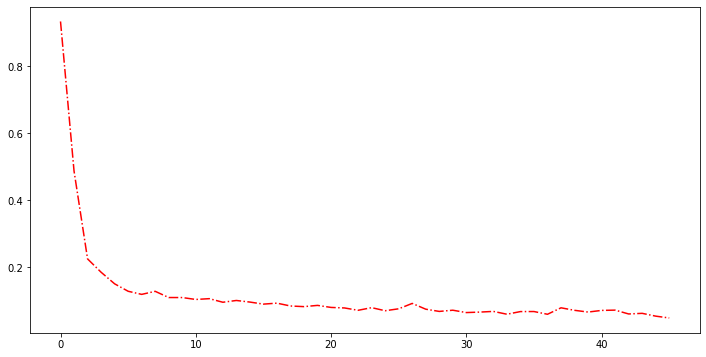

In [52]:
fig = plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss[avg_val_loss!=0], 'r-.')

### 5.1.2 Plot

In [ ]:
fig = plt.figure(figsize=(12, 6))
# ax = plt.gca()
loss_C = myHistory.history['val_loss']
epochs_C = myHistory.epoch
plt.plot(epochs_C, loss_C, 'b.-', label='Centralized')
plt.legend(loc='upper right')
plt.xlabel('Epochs (Iterations or Communication rounds)')
plt.ylabel('Validation Loss')

## 5.2 Runtime Curve

In [ ]:
fig = plt.figure(figsize=(12, 6))
# ax = plt.gca()
runtimes_C = np.diff(myHistory.timestamps)#.total_seconds() * 1000)
runtimes_C_s = [float(v.total_seconds())  for v in runtimes_C] 
epochs_C = myHistory.epoch[1:]
plt.plot(epochs_C, runtimes_C_s, 'b.-', label='Centralized')
plt.legend(loc='upper right')
plt.xlabel('Epochs (Iterations or Communication rounds)')
plt.ylabel('Duration (s)')

## 5.3 Predictions

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):

    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_xlim([-10,10])
    ax.set_ylim([-2,2])
    
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, history[:, 0], 'b', label='History_x')
    plt.plot(num_in, history[:, 1], 'b', label='History_y')
    plt.plot(np.arange(num_out), true_future, 'bo-',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), prediction, 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
def multi_step_plot_3D(history, true_future, prediction):
    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-10,10])
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    ax.plot3D(np.array(history[:, 0]), np.array(history[:, 1]), num_in, 'bo-', label='History')
    ax.plot3D(np.array(true_future[:,0]), np.array(true_future[:,1]), np.arange(num_out), 'bo',
           label='True Future')
    if prediction.any():
        ax.plot3D(np.array(prediction[:,0]), np.array(prediction[:,1]), np.arange(num_out), 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
# Stanford validation set
for x, y in val_set.take(3):
    multi_step_plot_3D(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])
    multi_step_plot(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])

# OLD CODE

# 2. Client-partioned Federated Learning from Trajectory Data

## 2.1 Load Distributed Data

In [ ]:
path = '../data/short_data/avoidance_20200127_1615**.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {}
last_sample_keys = {}

for filename in glob.iglob(path):
    print(filename)
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = data[0]
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples.keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[rid]):
                    samples[rid][last_key] = []
                samples[rid][last_key].append((x1, x2))
                if len(samples[rid][last_key]) == 99:
                    del samples[rid][last_key][98]
                    last_sample_keys[rid]+=1
            else:
                samples.update({rid: {}})
                samples[rid].update({0: [(x1, x2)]})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[rid] and len(samples[rid][last_key]) != 0):
                last_sample_keys[rid]+=1

## 2.3 Visualize Data

In [ ]:
TIME_STEP = 0.1

colors = cm.rainbow(np.linspace(0, 1, len(samples.keys())))
cnt = 0

plt.figure()
for v in samples.values():
    for traj in v.values():
        if (len(traj) > 0):
            x, y = zip(*traj)
        plt.plot(x, y, color=colors[cnt])
    cnt += 1
    break
    
ax = plt.gca()
circle2 = plt.Circle((0, 0), 2, color='b', fill=False)
ax.add_artist(circle2)
plt.axis('square')
plt.show( )

In [ ]:
count_traj = sum(len(v) for v in samples.values())

print(count_traj)

In [ ]:
for k,v in samples.items():
    for kk, vv in v.items():
        if len(vv) != 98:
            print(len(v),len(vv))

## 2.4 Create Labels

In [ ]:
def tuple_list_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset.values())
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

## 2.5 Create tff Dataset and tf Dataset Per Client

In [ ]:
TRAIN_RATIO = 0.2
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
TIME_STEP = 0.1

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [ ]:
count = 1
dict_train_dataset = {}
dict_val_dataset = {}
for v in samples.values():
    tot_samples = round(len(v)/5)
    train_split = round(TRAIN_RATIO * tot_samples)
    x_train, y_train = tuple_list_data(v, 0, train_split, PAST_HISTORY)
    x_val, y_val = tuple_list_data(v, train_split, tot_samples, PAST_HISTORY)
    dict_train_dataset.update({count: (x_train, y_train)})
    dict_val_dataset.update({count: (x_val, y_val)})
    count+=1
    
#     train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#     train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#     val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#     val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
print(x_train.shape, y_train.shape)

In [ ]:
tff_train_set = tff.simulation.FromTensorSlicesClientData(dict_train_dataset)
tff_val_set = tff.simulation.FromTensorSlicesClientData(dict_val_dataset)

In [ ]:
filehandler = open('tff_train_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_train_set, filehandler)
filehandler = open('tff_val_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_val_set, filehandler)

In [ ]:
print(tff_train_set.client_ids)
print(tff_train_set._output_shapes)
# print(vars(tff_train_set))

In [ ]:
def preprocess(dataset):
    return (
      dataset.cache()
      #form minibatches
      .batch(BATCH_SIZE))

In [ ]:
example_dataset = train_set

In [ ]:
print(example_dataset)
print(tf.data.experimental.get_structure(example_dataset))

In [ ]:
def data(client, source=tff_train_set):
    return preprocess(source.create_tf_dataset_for_client(client)).take(2)

clients = [1, 2, 3]

train_datasets = [data(client) for client in clients]

# We concatenate the test datasets for evaluation with Keras.
test_dataset = functools.reduce(
    lambda d1, d2: d1.concatenate(d2),
    [data(client, tff_val_set) for client in clients])

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
tff.framework.set_default_executor(tff.framework.create_local_executor())

## Serialize the keras model into a tff model

In [ ]:
BATCH_SIZE=16
SEQ_LENGTH=49

In [ ]:
#del simple_lstm_model
simple_lstm_model = tf.keras.models.load_model('pretrained_lstm.h5', compile=False)

In [ ]:
def tff_model():
    x = tf.constant(np.random.uniform(-2., 2., size=[BATCH_SIZE, SEQ_LENGTH, 2]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone =tf.keras.models.clone_model(simple_lstm_model)
    keras_model_clone.compile(optimizer='adam', loss='mean_absolute_error')
    return tff.learning.from_compiled_keras_model(keras_model_clone,dummy_batch)

In [ ]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.build_federated_averaging_process(model_fn=tff_model)

In [ ]:
state = fed_avg.initialize()

In [ ]:
state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in simple_lstm_model.trainable_weights],
    non_trainable_weights=[
        v.numpy() for v in simple_lstm_model.non_trainable_weights
    ])

In [ ]:
NUM_ROUNDS=3
simple_lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

def keras_evaluate(state, round_num):
    tff.learning.assign_weights_to_keras_model(simple_lstm_model, state.model)
    print('Evaluating before training round', round_num)
    simple_lstm_model.evaluate(example_dataset, steps=2)

for round_num in range(NUM_ROUNDS):
    keras_evaluate(state, round_num)
    # N.B. The TFF runtime is currently fairly slow,
    # expect this to get significantly faster in future releases.
    state, metrics = fed_avg.next(state, train_datasets)
    print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

# 3. Continuous Data Collection and Multi-Hop Network

## 3.3 Simulation

In [ ]:
print(neighbors['205449'][1][3])

# 4. Graphs

## 4.1 Centralized Version

## Average Consensus

# Suggested extensions

This tutorial is just the first step! Here are some ideas for how you might try extending this notebook:
  * Write a more realistic training loop where you sample clients to train on randomly.
  * Use "`.repeat(NUM_EPOCHS)`" on the client datasets to try multiple epochs of local training (e.g., as in [McMahan et. al.](https://arxiv.org/abs/1602.05629)). See also [Federated Learning for Image Classification](federated_learning_for_image_classification.md) which does this.
  * Change the `compile()` command to experiment with using different optimization algorithms on the client.
  * Try the `server_optimizer` argument to `build_federated_averaging_process` to try different algorithms for applying the model updates on the server.
  * Try the `client_weight_fn` argument to to `build_federated_averaging_process` to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. `client_weight_fn=lambda _: tf.constant(1.0)`.

## Redis

In [ ]:
import redis

In [ ]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [ ]:
# r.keys()
r.set('foo', 'bar')

In [ ]:
r.get('foo')

In [ ]:
%timeit r.set('foo', 'bar')